In [2]:
import sqlite3

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Introduction

The `home_team_win_model.ipynb` notebook is dedicated to developing a predictive model for football match outcomes, particularly on forecasting home team victories. The model utilizes data from the top five football leagues, covering seasons from 2008/2009 to 2014/2015.

The model creation process initiates with an extensive data preprocessing stage. This stage involves generating the target variable, removing unnecessary columns, managing missing values, and encoding categorical variables. To ensure the model's robustness, the independent variables are carefully examined for multicollinearity, and any variables contributing to this issue are removed.

Several machine learning models are trained, including Logistic Regression, Random Forest, Support Vector Machine, K-nearest neighbors, and Gradient Boosting. The Logistic Regression model is chosen for its optimal balance between precision and recall. It is further enhanced by tuning its hyperparameters and applying Principal Component Analysis (PCA) to reduce the data's dimensionality.

The final part of the project involves a practical application of the model in a betting scenario for the 2015/2016 season. A betting strategy is devised where a bet is placed only when the model predicts a 'Win' for the home team and the odds provided by the model are lower than the odds offered by the betting company. This strategy not only proves the model's effectiveness but also results in a profit for the 2015/2016 season.

In [3]:
matches_top_5 = pd.read_csv('matches_top_5.csv')

In [4]:
matches_top_5.head()

,match_api_id,season,date,home_team_goal,away_team_goal,stage,league_name,home_team,away_team,home_player_1,...,midfielders_away_rating,midfielders_away_total_rating,forwards_home_rating,forwards_home_total_rating,forwards_away_rating,forwards_away_total_rating,home_team_outlier,away_team_outlier,home_team_rating_category,away_team_rating_category
0,499320,2008/2009,2008-08-16,2,1,1,Germany 1. Bundesliga,VfL Wolfsburg,1. FC Köln,70.0,...,71.0,284.0,75.0,150.0,74.0,148.0,0,0,High,High
1,499343,2008/2009,2008-08-29,0,2,3,Germany 1. Bundesliga,Karlsruher SC,1. FC Köln,68.0,...,69.2,346.0,69.0,69.0,78.0,78.0,0,0,Medium,High
2,499358,2008/2009,2008-09-20,2,0,5,Germany 1. Bundesliga,DSC Arminia Bielefeld,1. FC Köln,62.0,...,70.2,351.0,73.0,146.0,78.0,78.0,0,0,Medium,High
3,499378,2008/2009,2008-10-04,1,2,7,Germany 1. Bundesliga,Borussia Mönchengladbach,1. FC Köln,71.0,...,65.0,325.0,70.0,70.0,78.0,78.0,0,0,Medium,High
4,499390,2008/2009,2008-10-24,2,0,9,Germany 1. Bundesliga,Bayer 04 Leverkusen,1. FC Köln,78.0,...,65.0,325.0,73.5,147.0,78.0,78.0,0,0,High,High


# Data Preprocessing

- Creation of the Target Variable Column

During the Exploratory Data Analysis (EDA) stage, we noted that the average number of goals per game for each season fluctuates between 2.2 and 3.1. The most prevalent bets are placed on whether the total goals will be under or over 2.5, or 3.5. However, we lack data on the odds provided by betting companies and the specific under/over bets they offered. As a result, we will generate a new column, 'goals_target,' where 'O' signifies over two goals and 'U' signifies under two goals. This would be a good starting point for prediction, especially if the model accurately predicts unders. This model would also be effective when betting companies offer under/over bets of 3.5 goals, not just 2.5.

In [5]:
matches_top_5['goals_target'] = np.where(matches_top_5['home_team_goal'] + matches_top_5['away_team_goal'] > 2, 'O',
                                         'U')

Let`s check the distribution of the target variable

In [6]:
matches_top_5['goals_target'].value_counts()

goals_target
O    7302
U    7283
Name: count, dtype: int64

The balance in the distribution of the target variable is beneficial for the model.

- A drop of  unnecessary columns

In [7]:
teams = ['home', 'away']
columns_to_drop = ['date']

for team in teams:
    columns_to_drop += [f'{team}_team_goal', f'{team}_team', f'{team}_team_rating_category', f'{team}_team_points']

for team in teams:
    for i in range(1, 12):
        columns_to_drop += [f'{team}_player_{i}', f'{team}_player_Y{i}', f'{team}_player_{i}_age']

matches_top_5 = matches_top_5.drop(columns=columns_to_drop)

- Check for Nan values

In [8]:
matches_top_5.isna().sum()

match_api_id                      0
season                            0
stage                             0
league_name                       0
result                            0
average_home_player_rating        0
average_away_player_rating        0
players_rating_difference         0
home_players_age                  0
away_players_age                  0
players_age_difference            0
home_team_form                    1
away_team_form                    1
home_team_formations              0
away_team_formations              0
home_team_rolling_goals           1
home_team_rolling_conceded        1
away_team_rolling_goals           1
away_team_rolling_conceded        1
Home_GK                          38
Away_GK                          29
defenders_home_rating             0
defenders_home_total_rating       0
defenders_away_rating             0
defenders_away_total_rating       0
midfielders_home_rating           0
midfielders_home_total_rating     0
midfielders_away_rating     

In [9]:
num_rows_with_nan = matches_top_5.isna().any(axis=1).sum()

total_rows = len(matches_top_5)

percentage = (num_rows_with_nan / total_rows) * 100

percentage

0.7610558793280768

Percentage of rows with Nan values is 0.76% so we can drop them.

In [10]:
matches_top_5 = matches_top_5.dropna()

- Replace of 'Draw' and 'Lose' values in the 'result' column

We will substitute the 'Draw' and 'Lose' values in the 'result' column with 'NW' (No Win). This modification will enable us to construct a binary classification model, with the target variable being either 'Win' or 'NW.' The objective of this model is to forecast when the home team will win. For our purposes, a draw or loss is treated the same way.

In [11]:
matches_top_5['result'] = matches_top_5['result'].replace(['Draw', 'Lose'], 'NW')

- Encode of team formations

Let's first check the number of unique formations used to decide on the encoding method.

In [12]:
home_team_formations_unique = matches_top_5['home_team_formations'].unique()
away_team_formations_unique = matches_top_5['away_team_formations'].unique()

print("Unique values in home_team_formations:", home_team_formations_unique)
print("Unique values in away_team_formations:", away_team_formations_unique)

Unique values in home_team_formations: ['4-5-1' '4-4-2' '4-3-3' '3-5-2' '3-4-3' '3-6-1' '5-3-2' '5-4-1' '4-4-1']
Unique values in away_team_formations: ['4-5-1' '4-4-2' '4-3-3' '3-5-2' '5-4-1' '5-3-2' '3-6-1' '3-4-3' '3-4-2'
 '4-3-2']


We will encode the 'home_team_formations' and 'away_team_formations' columns. To avoid creating too many columns , we will change formations to 3 types, Defensive, Balanced and Offensive. It will depend on with how many forwards the team is playing. If the formation ends with 1, it will be Defensive, if it ends with 2, it will be Balanced and if it ends with 3, it will be Offensive.

In [13]:
def map_formation_to_style(formation):
    last_number = int(formation[-1])
    if last_number == 1:
        return 'Defensive'
    elif last_number == 2:
        return 'Normal'
    elif last_number == 3:
        return 'Attacking'
    else:
        return formation


matches_top_5['home_team_formations'] = matches_top_5['home_team_formations'].apply(map_formation_to_style)
matches_top_5['away_team_formations'] = matches_top_5['away_team_formations'].apply(map_formation_to_style)

Now we will encode the 'home_team_formations' and 'away_team_formations' columns for the model.

In [14]:
matches_top_5 = pd.get_dummies(matches_top_5, columns=['home_team_formations', 'away_team_formations'])

- Check for multicollinearity

We will check for multicollinearity between the independent variables. We will use the Variance Inflation Factor (VIF) to check for multicollinearity. 

In [15]:
numeric_cols = matches_top_5.select_dtypes(include=['int64', 'float64'])

X = numeric_cols
y = matches_top_5['result']

X = sm.add_constant(X)

vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [round(variance_inflation_factor(X.values, i), 2) for i in range(X.shape[1])]

vif

C:\Users\duome\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,const,846.77
1,match_api_id,5.13
2,stage,1.02
3,average_home_player_rating,1744528.76
4,average_away_player_rating,1736298.27
5,players_rating_difference,2148411.61
6,home_players_age,inf
7,away_players_age,inf
8,players_age_difference,inf
9,home_team_form,4.52


We can see that there is multicollinearity between the independent variables. We will drop the 'average_home_player_rating,' 'average_away_player_rating,' 'home_players_age', and 'away_players_age' columns.

In [16]:
matches_top_5 = matches_top_5.drop(
    ['average_home_player_rating', 'average_away_player_rating', 'home_players_age', 'away_players_age'], axis=1)

'Draw' and 'Lose' values in the 'result' column were replaced with 'NW' (No Win). The 'home_team_formations' and 'away_team_formations' columns were encoded. Now, we will save this data frame and train the models.

In [17]:
matches_top_5.to_csv('matches_top_5_model.csv', index=False)

# Machine learning models

We will use the following models to train the data:
- Logistic Regression
- Random Forest
- Support Vector Machine
- K-Nearest Neighbors
- Gradient Boosting

In [18]:
features = matches_top_5.drop(['league_name', 'season', 'result', 'match_api_id', 'goals_target'], axis=1)
target = matches_top_5['result']

train_data = matches_top_5[matches_top_5['season'] != '2015/2016']
test_data = matches_top_5[matches_top_5['season'] == '2015/2016']

features_train = train_data.drop(['league_name', 'season', 'result', 'match_api_id', 'goals_target'], axis=1)
target_train = train_data['result']

features_test = test_data.drop(['league_name', 'season', 'result', 'match_api_id', 'goals_target'], axis=1)
target_test = test_data['result']

models = {
    "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": make_pipeline(StandardScaler(), SVC()),
    "K-Nearest Neighbors": make_pipeline(StandardScaler(), KNeighborsClassifier()),
    "Gradient Boosting": GradientBoostingClassifier()
}

results_df = pd.DataFrame()

for model_name, model in models.items():
    model.fit(features_train, target_train)
    predicted_results = model.predict(features_test)
    report = classification_report(target_test, predicted_results, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df['model'] = model_name
    results_df = pd.concat([results_df, report_df])

win_results_df = results_df[results_df.index == 'Win']

win_results_df

,precision,recall,f1-score,support,model
Win,0.577049,0.435644,0.496474,808.0,Logistic Regression
Win,0.557118,0.392327,0.460421,808.0,Random Forest
Win,0.590385,0.379950,0.462349,808.0,Support Vector Machine
Win,0.506831,0.459158,0.481818,808.0,K-Nearest Neighbors
Win,0.575540,0.396040,0.469208,808.0,Gradient Boosting


Logistic regression model has the best ratio of precision and recall. We will try to improve it and use for betting.

## Logistic Regression

We will check the coefficients of the logistic regression model to see which features are the most important.

In [19]:
model = models['Logistic Regression']

coefficients = model.named_steps['logisticregression'].coef_[0]

coefficients_df = pd.DataFrame(coefficients, columns=['Coefficient'])

coefficients_df.index = features_train.columns

coefficients_df = coefficients_df.sort_values('Coefficient', ascending=False)

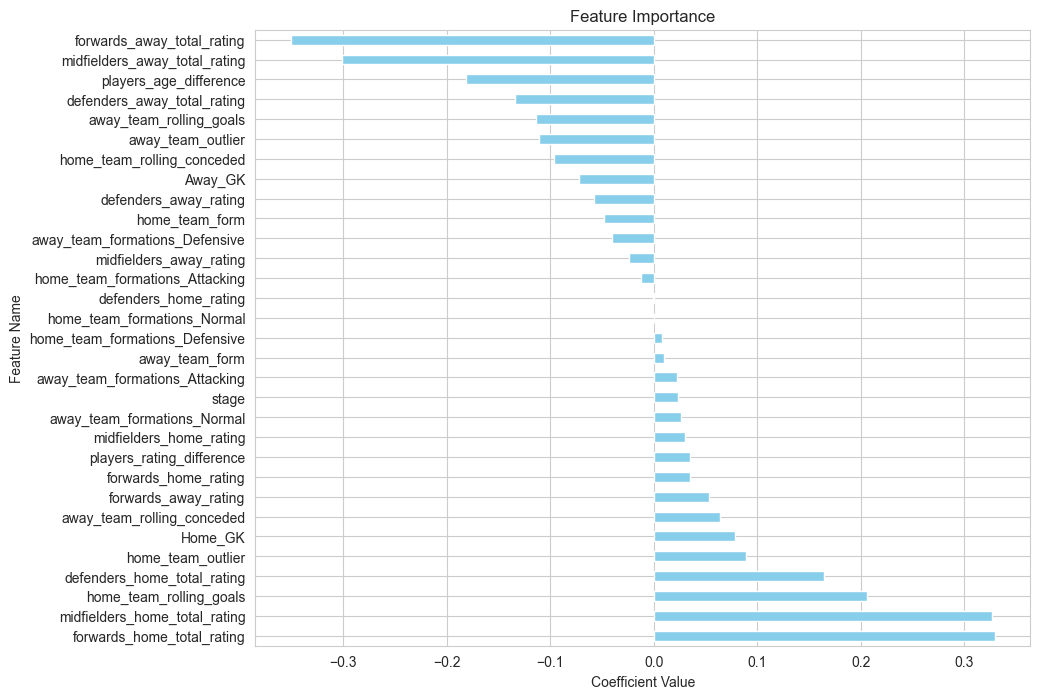

In [20]:
plt.figure(figsize=(10, 8))
coefficients_df['Coefficient'].plot(kind='barh', color='skyblue')
plt.title('Feature Importance')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.show()

### Explained Variance by Components

Now, we will generate a plot to illustrate the variance explained by each component. This will aid us in determining the number of components to utilize in Principal Component Analysis (PCA).

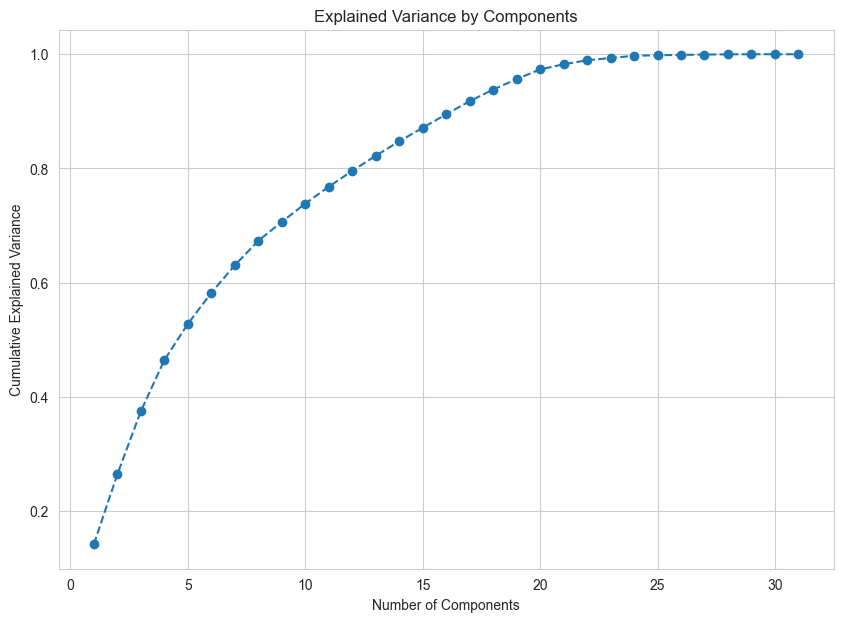

In [21]:
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)

pca = PCA()
pca.fit(features_train_scaled)

explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 7))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

### PCA and Hyperparameter Tuning

In [22]:
pca = PCA(n_components=20)

pipeline = Pipeline(steps=[('s', StandardScaler()), ('pca', pca), ('m', LogisticRegression(max_iter=1000))])

param_grid = {
    'm__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

custom_scorer = make_scorer(precision_score, pos_label='Win')

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=custom_scorer)
grid_search.fit(features_train, target_train)

print("Best parameters: ", grid_search.best_params_)
print("Best precision: ", grid_search.best_score_)

best_model = grid_search.best_estimator_

Best parameters:  {'m__C': 0.001}
Best precision:  0.6098499075816447


In [23]:
predicted_test = best_model.predict(features_test)

report = classification_report(target_test, predicted_test)

print(report)

              precision    recall  f1-score   support

          NW       0.62      0.79      0.70      1014
         Win       0.60      0.40      0.48       808

    accuracy                           0.62      1822
   macro avg       0.61      0.59      0.59      1822
weighted avg       0.61      0.62      0.60      1822


The precision of our model has increased from 57 to 60, while the recall has slightly decreased from 43 to 40. However, in our case, precision is more crucial. Therefore, we will consider this as our optimal model and proceed to use it for testing in the betting scenario.

In [24]:
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

# Testing the Betting Strategy

Now, we will compute the prediction odds, combine this data with the data from betting companies, and evaluate if our model outperforms the bookmakers.

In [25]:
loaded_model = joblib.load('best_model.pkl')

predicted_test = loaded_model.predict(features_test)
predicted_probabilities = loaded_model.predict_proba(features_test)

predictions_df = test_data.copy()
predictions_df['Predicted_Result'] = predicted_test
predictions_df['Probability_NW'] = predicted_probabilities[:, 0]
predictions_df['Probability_Win'] = predicted_probabilities[:, 1]

odds_NW = 1 / predicted_probabilities[:, 0]
odds_Win = 1 / predicted_probabilities[:, 1]

predictions_df['Odds_NW'] = odds_NW
predictions_df['Odds_Win'] = odds_Win

predictions_df['Odds_NW'] = predictions_df['Odds_NW'].round(2)
predictions_df['Odds_Win'] = predictions_df['Odds_Win'].round(2)

Now, we will retrieve the betting odds from various companies for matches in the 2015/2016 season played in the top 5 leagues, which we have previously analyzed and used to train our model. We are taking just the odds of the home team win because we will bet only on the home team win; column names are coded in this way: if it is William Hill, it will be WHH - which means William Hill Home Win, if it's bet365 it will be B365H - means Bet365 Home Win if WHA - William Hill Away Win, B365A - Bet365, if WHD - William Hill Draw, B365D - Bet365 Draw. So we will query all the columns that end with h, and then we will check the columns and if we need to remove some of them

In [26]:
conn = sqlite3.connect('football.sqlite')

query = """
SELECT * 
FROM match 
WHERE league_id IN ( 1729, 4769, 7809, 10257, 21518 )
AND season = '2015/2016'
"""

betting_odds = pd.read_sql_query(query, conn)

conn.close()

betting_odds = betting_odds[['match_api_id'] + [col for col in betting_odds.columns if col.endswith('H')]]

In [27]:
betting_odds.head(10)

,match_api_id,B365H,BWH,IWH,LBH,PSH,WHH,SJH,VCH,GBH,BSH
0,1987032,1.29,1.28,1.33,1.29,1.31,1.30,None,1.30,None,None
1,1987033,2.00,2.00,2.10,2.05,1.95,1.91,None,2.00,None,None
2,1987034,1.36,1.40,1.33,1.40,1.39,1.40,None,1.40,None,None
3,1987035,1.70,1.70,1.70,1.75,1.70,1.73,None,1.73,None,None
4,1987036,1.95,2.00,2.00,2.00,1.99,2.00,None,2.00,None,None
5,1987037,1.65,1.65,1.65,1.67,1.65,1.62,None,1.67,None,None
6,1987038,2.88,2.80,2.65,2.88,2.88,2.70,None,2.88,None,None
7,1987039,2.55,2.60,2.40,2.62,2.52,2.60,None,2.60,None,None
8,1987040,3.40,3.20,2.90,3.40,3.48,3.30,None,3.40,None,None
9,1987041,5.75,4.75,5.10,5.50,5.75,5.50,None,5.50,None,None


We can observe that three companies have null values. Now, we will verify whether these null values are present in all rows or just in some of them.

In [28]:
betting_odds.isna().sum()

match_api_id       0
B365H              1
BWH                1
IWH                0
LBH                1
PSH                1
WHH                0
SJH             1826
VCH                1
GBH             1826
BSH             1826
dtype: int64

SJH GBH BSH has just None values, we will drop these columns

In [29]:
betting_odds.drop(columns=['PSH', 'SJH', 'BSH', 'GBH'], inplace=True)

Now, we will merge the betting odds with the predictions dataframe.

In [30]:
matches_top_5_sub = predictions_df[['match_api_id', 'Odds_Win', 'Predicted_Result', 'result']]

In [31]:
betting_test = pd.merge(betting_odds, matches_top_5_sub, on='match_api_id', how='left')

In [32]:
betting_test.head()

,match_api_id,B365H,BWH,IWH,LBH,WHH,VCH,Odds_Win,Predicted_Result,result
0,1987032,1.29,1.28,1.33,1.29,1.30,1.30,1.80,Win,NW
1,1987033,2.00,2.00,2.10,2.05,1.91,2.00,2.11,NW,NW
2,1987034,1.36,1.40,1.33,1.40,1.40,1.40,1.73,Win,NW
3,1987035,1.70,1.70,1.70,1.75,1.73,1.73,2.03,NW,NW
4,1987036,1.95,2.00,2.00,2.00,2.00,2.00,2.34,NW,Win


Now, we will calculate the betting results for each betting company. Our calculation will be as follows:
- If the predicted result is 'Win' and the odds are lower than the betting company's, we will bet 1 unit.
- If the predicted result is 'Win' and the odds are higher than the betting company's odds, we will not bet.
- If the predicted result is 'No Win,' we will not bet.

In [33]:
betting_companies = ['B365H', 'BWH', 'IWH', 'LBH', 'WHH', 'VCH']

for company in betting_companies:
    betting_test[f'{company}_betting_result'] = np.where(
        (betting_test['Predicted_Result'] == 'Win') & (betting_test['Odds_Win'] < betting_test[company]) & (
                betting_test['Predicted_Result'] == betting_test['result']), betting_test[company],
        np.where((betting_test['Predicted_Result'] == 'Win') & (betting_test['Odds_Win'] < betting_test[company]) & (
                betting_test['Predicted_Result'] != betting_test['result']), -1, 0))

Next, we will compute the overall betting outcome for each betting company and the cumulative betting outcome.

In [34]:
betting_companies = ['B365H', 'BWH', 'IWH', 'LBH', 'WHH', 'VCH']

betting_results = {company: betting_test[f'{company}_betting_result'].sum() for company in betting_companies}

total_betting_result = round(sum(betting_results.values()), 2)

betting_results['Total'] = total_betting_result

betting_results_df = pd.DataFrame([betting_results])
betting_results_df = betting_results_df.set_index(pd.Index(['Win/Loose']))
betting_results_df

,B365H,BWH,IWH,LBH,WHH,VCH,Total
Win/Loose,57.01,64.89,57.05,51.99,62.52,68.53,361.99


# Summary and Outcomes of the Home Team Victory Prediction Model

In this project, our objective was to predict the outcomes of football matches, with a specific focus on the home team's victories. We used data from the top five football leagues spanning the seasons from 2008/2009 to 2014/2015 to train our model.

The initial phase involved data preprocessing, which encompassed creating the target variable, removing unnecessary columns, handling missing values, and encoding categorical variables. We also examined the independent variables for multicollinearity and eliminated some to prevent this issue.

Subsequently, we trained several machine learning models, including Logistic Regression, Random Forest, Support Vector Machine, K-Nearest Neighbors, and Gradient Boosting. After assessing these models based on their precision and recall, we chose the Logistic Regression model due to its optimal balance between these two metrics.

We further enhanced the Logistic Regression model by tuning its hyperparameters and applying Principal Component Analysis (PCA) to reduce the dimensionality of our data. This resulted in an improvement in our model's precision from 57% to 60%.

Finally, we tested our model in a betting scenario for the 2015/2016 season. We devised a betting strategy where we would place a bet only when our model predicted a 'Win' for the home team and the odds provided by our model were lower than the odds offered by the betting company. Utilizing this strategy, our model would have yielded a profit of 361.99 units in the 2015/2016 season.

# Suggestions for Further Improvement

For further enhancement of our model, we could consider the following strategies:

1. **Ensemble Methods**: We could combine the predictions of multiple models for improved performance. Experimenting with different ensemble methods and base classifiers could yield better results.

2. **Deep Learning**: We could utilize neural networks to capture complex patterns in the data. Experimenting with different architectures and hyperparameters could optimize the performance of the deep learning model.

3. **Bayesian Optimization**: This advanced method for hyperparameter tuning could help us select the best-performing hyperparameters based on a probabilistic model.

4. **Betting Strategy**: We could refine the strategy based on the model's predictions. Adjusting the bet amount based on the model's prediction confidence could increase the model's profitability in a betting scenario.
